In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


* ⏱️ 'trip_duration': How long did the journey last?[in Seconds]
* 🛣️ 'distance_traveled': How far did the taxi travel?[in Km]
* 🧑‍🤝‍🧑 'num_of_passengers': How many passengers were in the taxi?
* 💵 'fare': What's the base fare for the journey?[In INR]
* 💲 'tip': How much did the driver receive in tips?[In INR]
* 🎀 'miscellaneous_fees': Were there any additional charges during the trip?e.g. tolls, convenience fees, GST
* etc.[In INR]
* 💰 'total_fare': The grand total for the ride (this is your prediction target!).[In INR]
* ⚡ 'surge_applied': Was there a surge pricing applied? Yes or no?

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

In [3]:
train_df = pd.read_csv('taxi_train.csv')
test_df = pd.read_csv('taxi_test.csv')
print("Loaded dataset")

Loaded dataset


In [4]:
train_df.head()

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,total_fare,surge_applied
0,748.0,2.75,1.0,75.00,24,6.300,105.300,0
1,1187.0,3.43,1.0,105.00,24,13.200,142.200,0
2,730.0,3.12,1.0,71.25,0,26.625,97.875,1
3,671.0,5.63,3.0,90.00,0,9.750,99.750,0
4,329.0,2.09,1.0,45.00,12,13.200,70.200,0


# **Trip Duration Analysis**

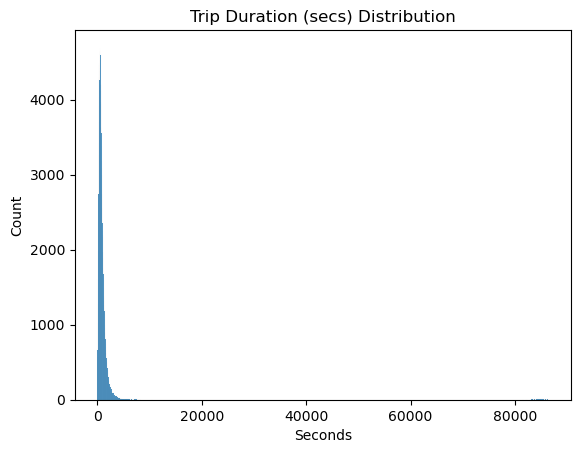

In [5]:
sns.histplot(train_df['trip_duration'])
plt.title('Trip Duration (secs) Distribution')
plt.xlabel('Seconds')
plt.ylabel('Count')
plt.show()

In [6]:
train_df['trip_duration'].describe() # secs

count    209673.000000
mean       1173.181478
std        4775.653621
min           0.000000
25%         446.000000
50%         707.000000
75%        1098.000000
max       86387.000000
Name: trip_duration, dtype: float64

1. Minimum Trip Duration is 0, which might mean cancelled trips. We can think of applying some minute amount for cancellation (Cancellation Fee)
2. Most of the trips are 450-1000 sec duration (8-16mins), so mostly in the cities
3. Maximum Duration is an outlier - 86400 secs (24 hours trip), so most probably out-of-station trip. These types of trips are outlier (Any reason why?). Do we have to consider it a posibility that such trips happen, if so then this might increase the scope of trip duration in general and might affect the ML model results

In [7]:
len(train_df[train_df['trip_duration'] >= 3600]) # secs

3076

# **Distance Travelled Analysis**

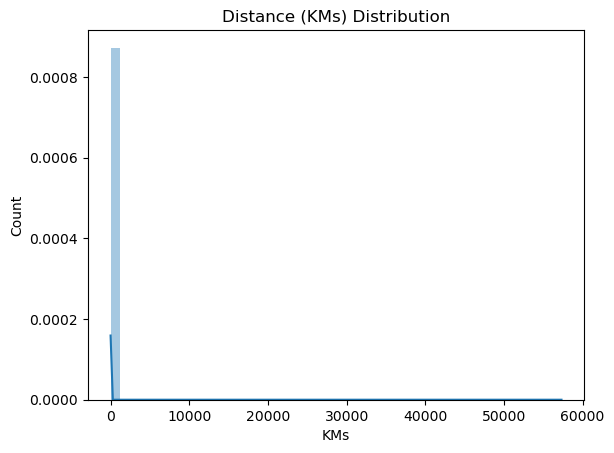

In [8]:
sns.distplot(train_df['distance_traveled'])
plt.title('Distance (KMs) Distribution')
plt.xlabel('KMs')
plt.ylabel('Count')
plt.show()

In [9]:
train_df['distance_traveled'].describe()

count    209673.000000
mean          5.054431
std         125.217419
min           0.020000
25%           1.950000
50%           3.200000
75%           5.730000
max       57283.910000
Name: distance_traveled, dtype: float64

1. Minimum distance travelled is 0.02 KMs i.e. 20m, which should not be the case as minimum trip duration is 0secs. Might mean that the data is corrupted
2. 57284 is very high number of KMs which might be the trip which had highest duration

In [10]:
train_df[train_df['distance_traveled'] >= 100].shape

(21, 8)

In [11]:
# Validation (Edge Cases)
train_df[train_df['trip_duration'] == 0]['distance_traveled']

1762      0.02
3074      0.18
4108      0.16
4535      0.02
12418     0.06
15019     7.19
36462     0.06
46617     0.11
51024     0.05
51257     0.43
57763     0.13
65008     0.23
69620     0.18
75746     0.10
80323     0.02
82499     0.24
85904     0.21
98332     0.02
130369    0.10
131446    0.16
139456    0.11
140179    0.18
144462    0.40
154787    3.22
174252    0.11
181260    0.11
181484    0.05
189435    0.06
189685    0.29
190278    0.37
201019    0.11
203692    0.23
208249    0.05
Name: distance_traveled, dtype: float64

# **Number of Passengers Analysis**

In [12]:
train_df['num_of_passengers'].value_counts(dropna=False).sort_index()

num_of_passengers
0.0       753
1.0    179229
2.0     17896
3.0      2757
4.0       908
5.0      4713
6.0      3382
7.0         2
8.0        25
9.0         8
Name: count, dtype: int64

1. Number of passengers can't be zero, there is some corrupted data, might replace all the 0 passengers with base minimum 1, to justify to the model
2. Number of passengers being >6 were less because there are more sedans than MUVs and SUVs. Might charge more money if car type changes

# **Surge Analysis**

In [13]:
train_df['surge_applied'].value_counts(dropna=False).sort_index()

surge_applied
0    150855
1     58818
Name: count, dtype: int64

In [14]:
train_df['surge_applied'].value_counts(dropna=False).sort_index()*100/train_df.shape[0]

surge_applied
0    71.947747
1    28.052253
Name: count, dtype: float64

1. ABout 30% of time the trips were surge
2. Ideally surge should increase the price of the trip when all other parameters are constant

# **Trip Fare Analysis**

In [15]:
train_df[['fare','tip', 'miscellaneous_fees', 'total_fare']]

,fare,tip,miscellaneous_fees,total_fare
0,75.00,24,6.300,105.300
1,105.00,24,13.200,142.200
2,71.25,0,26.625,97.875
3,90.00,0,9.750,99.750
4,45.00,12,13.200,70.200
...,...,...,...,...
209668,150.00,47,5.800,202.800
209669,48.75,12,34.575,95.325
209670,63.75,0,6.000,69.750
209671,56.25,0,13.500,69.750


In [16]:
# Checking maths behind total fare calculation
train_df['final_fare_calculated_as_sum_of_components'] = train_df[['fare','tip', 'miscellaneous_fees']].sum(axis=1)
train_df[['final_fare_calculated_as_sum_of_components','total_fare']]

,final_fare_calculated_as_sum_of_components,total_fare
0,105.300,105.300
1,142.200,142.200
2,97.875,97.875
3,99.750,99.750
4,70.200,70.200
...,...,...
209668,202.800,202.800
209669,95.325,95.325
209670,69.750,69.750
209671,69.750,69.750


In [17]:
train_df[['final_fare_calculated_as_sum_of_components','total_fare']].dtypes

final_fare_calculated_as_sum_of_components    float64
total_fare                                    float64
dtype: object

In [18]:
train_df[train_df['final_fare_calculated_as_sum_of_components'] != train_df['total_fare']][['final_fare_calculated_as_sum_of_components','total_fare']]

,final_fare_calculated_as_sum_of_components,total_fare
160437,63.375,63.375


Seems to be datatype or precision error, otherwise the calculation seems legit

# **Feature Corelations**

In [19]:
train_df.isnull().sum()

trip_duration                                 0
distance_traveled                             0
num_of_passengers                             0
fare                                          0
tip                                           0
miscellaneous_fees                            0
total_fare                                    0
surge_applied                                 0
final_fare_calculated_as_sum_of_components    0
dtype: int64

In [20]:
train_df[train_df['surge_applied'] == 1]['total_fare']

2          97.875
5          71.625
7         178.575
10        171.450
11         90.450
           ...   
209652    253.500
209653    108.450
209654    300.375
209659    135.375
209669     95.325
Name: total_fare, Length: 58818, dtype: float64

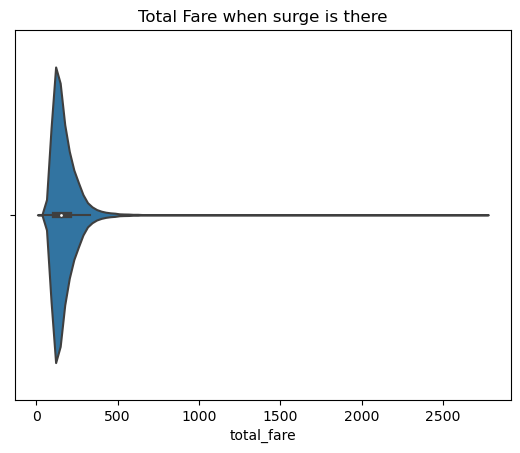

In [21]:
# Surge and Pricing
sns.violinplot(x=train_df[train_df['surge_applied'] == 1]['total_fare'].reset_index(drop=True))
plt.title('Total Fare when surge is there')
plt.show()

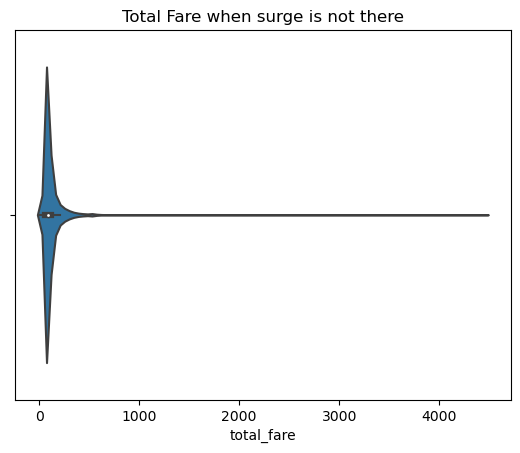

In [22]:
# Surge and Pricing
sns.violinplot(x=train_df[train_df['surge_applied'] != 1]['total_fare'].reset_index(drop=True))
plt.title('Total Fare when surge is not there')
plt.show()

Text(0.5, 1.0, 'Distance travelled Vs Price')

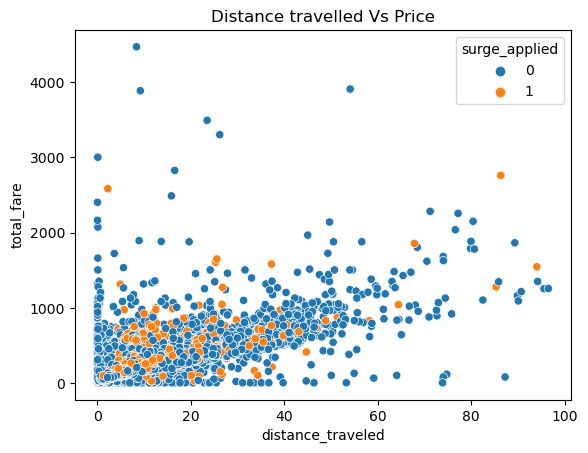

In [23]:
sns.scatterplot(x=train_df[train_df['distance_traveled']<100]['distance_traveled'], y=train_df['total_fare'], hue=train_df['surge_applied'])
plt.title('Distance travelled Vs Price')

1. From data it looks hard to say surge increased the fare, mostly because the data is imbalanced

In [24]:
train_df.columns

Index(['trip_duration', 'distance_traveled', 'num_of_passengers', 'fare',
       'tip', 'miscellaneous_fees', 'total_fare', 'surge_applied',
       'final_fare_calculated_as_sum_of_components'],
      dtype='object')

<Axes: >

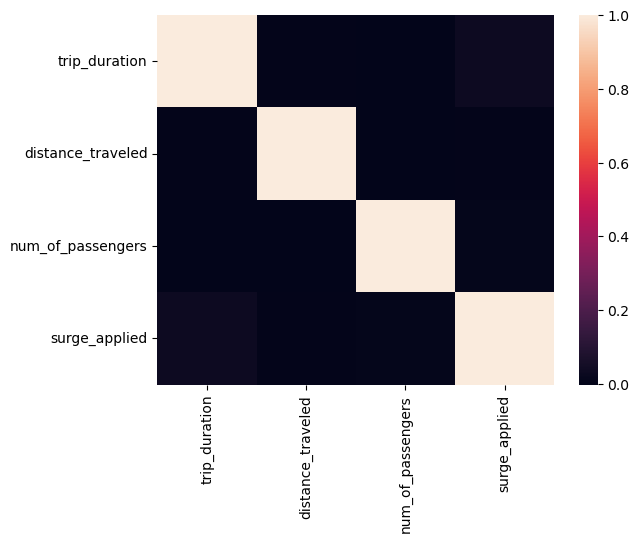

In [25]:
sns.heatmap(train_df[['trip_duration', 'distance_traveled', 'num_of_passengers','surge_applied']].corr())

As expected logically and numerically also, there is no correlation among features. Looks good for modelling

# **Modelling**

In [26]:
train_df

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,total_fare,surge_applied,final_fare_calculated_as_sum_of_components
0,748.0,2.75,1.0,75.00,24,6.300,105.300,0,105.300
1,1187.0,3.43,1.0,105.00,24,13.200,142.200,0,142.200
2,730.0,3.12,1.0,71.25,0,26.625,97.875,1,97.875
3,671.0,5.63,3.0,90.00,0,9.750,99.750,0,99.750
4,329.0,2.09,1.0,45.00,12,13.200,70.200,0,70.200
...,...,...,...,...,...,...,...,...,...
209668,1617.0,8.42,1.0,150.00,47,5.800,202.800,0,202.800
209669,438.0,1.29,1.0,48.75,12,34.575,95.325,1,95.325
209670,571.0,2.82,1.0,63.75,0,6.000,69.750,0,69.750
209671,491.0,2.16,1.0,56.25,0,13.500,69.750,0,69.750


In [27]:
train_df.columns

Index(['trip_duration', 'distance_traveled', 'num_of_passengers', 'fare',
       'tip', 'miscellaneous_fees', 'total_fare', 'surge_applied',
       'final_fare_calculated_as_sum_of_components'],
      dtype='object')

In [28]:
model_features = ['trip_duration', 'distance_traveled', 'num_of_passengers','surge_applied']
X = train_df[model_features]
y = train_df['fare']
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7, random_state=101)

In [29]:
X_train

,trip_duration,distance_traveled,num_of_passengers,surge_applied
189352,580.0,3.20,1.0,0
93048,2466.0,10.17,1.0,0
151052,2477.0,10.96,1.0,1
24514,569.0,3.65,1.0,0
122346,294.0,2.06,1.0,0
...,...,...,...,...
55293,1632.0,6.12,1.0,1
49751,701.0,2.85,1.0,0
136767,47.0,0.82,1.0,0
204614,1063.0,12.55,5.0,0


# **Standarization of data**

In [30]:
scaler = MinMaxScaler()

# Fitting on only X_train
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_train

array([[6.71420633e-03, 5.55129898e-05, 1.11111111e-01, 0.00000000e+00],
       [2.85469531e-02, 1.77187687e-04, 1.11111111e-01, 0.00000000e+00],
       [2.86742915e-02, 1.90978650e-04, 1.11111111e-01, 1.00000000e+00],
       ...,
       [5.44082237e-04, 1.39655320e-05, 1.11111111e-01, 0.00000000e+00],
       [1.23055195e-02, 2.18735145e-04, 5.55555556e-01, 0.00000000e+00],
       [5.86914243e-03, 3.80560748e-05, 1.11111111e-01, 0.00000000e+00]])

In [31]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [32]:
# y = m1x1 + m2x2 + m3x3 + m4x4 + c
print("Value of c=",model.intercept_ )

Value of c= 87.52738093109836


Means even if all parameters are minimum then fare is Rs.87

In [33]:
X_test = scaler.transform(X_test)
y_pred = model.predict(X_test)
y_pred

array([ 93.67198447,  93.36927219, 117.74932285, ..., 122.69760683,
        88.57037979,  89.08675496])

In [34]:
r2_score(y_test, y_pred)

0.047365568507285905

Not good R2 Score, highly erronous model, reasons?
1. Insufficient features to predict fare correctly
2. Model could not learn properly from the data
3. Problems due to outliers, need to remove and then check

Text(0, 0.5, 'Predicted Fare')

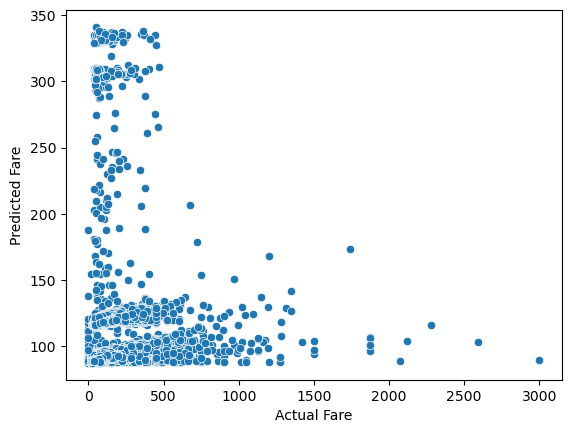

In [35]:
sns.scatterplot(x = y_test, y = y_pred)
plt.xlabel('Actual Fare')
plt.ylabel('Predicted Fare')

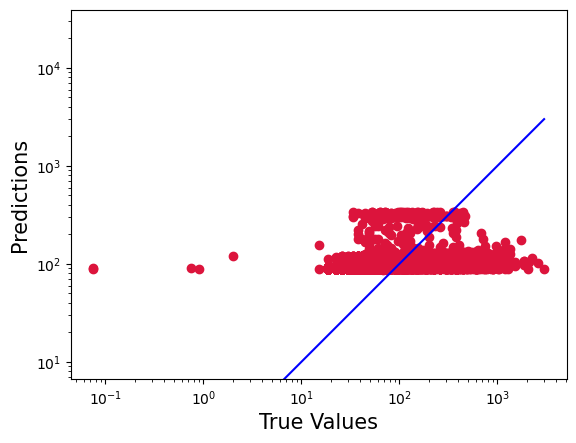

In [36]:
# plt.figure(figsize=(10,10))
# plt.scatter(true_value, predicted_value, c='crimson')
# plt.yscale('log')
# plt.xscale('log')

# p1 = max(max(predicted_value), max(true_value))
# p2 = min(min(predicted_value), min(true_value))
# plt.plot([p1, p2], [p1, p2], 'b-')
# plt.xlabel('True Values', fontsize=15)
# plt.ylabel('Predictions', fontsize=15)
# plt.axis('equal')
# plt.show()

true_value = y_test
predicted_value = y_pred 

plt.scatter(true_value, predicted_value, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(predicted_value), max(true_value))
p2 = min(min(predicted_value), min(true_value))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

# **Removing Outliers**

In [37]:
def remove_outliers(series):
    # Calculate the first quartile (Q1), third quartile (Q3), and IQR
    q1 = np.percentile(series, 25)
    q3 = np.percentile(series, 75)
    iqr = q3 - q1
    
    # Calculate the lower and upper bounds for outliers
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Remove outliers from the series
#     cleaned_series = [x for x in series if lower_bound <= x <= upper_bound]
    
    return lower_bound, upper_bound

In [38]:
# ['trip_duration', 'distance_traveled', 'num_of_passengers', 'fare',
#        'tip', 'miscellaneous_fees', 'total_fare', 'surge_applied',
#        'final_fare_calculated_as_sum_of_components']

In [39]:
# Getting old (non-normalized training testing split)
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7, random_state=101)

In [40]:
X_train

,trip_duration,distance_traveled,num_of_passengers,surge_applied
189352,580.0,3.20,1.0,0
93048,2466.0,10.17,1.0,0
151052,2477.0,10.96,1.0,1
24514,569.0,3.65,1.0,0
122346,294.0,2.06,1.0,0
...,...,...,...,...
55293,1632.0,6.12,1.0,1
49751,701.0,2.85,1.0,0
136767,47.0,0.82,1.0,0
204614,1063.0,12.55,5.0,0


# **Removing outliers only from training sample, so as to not face Data Leakage**

In [41]:
X_train['trip_duration_lb'], X_train['trip_duration_ub'] = remove_outliers(X_train['trip_duration'])
X_train

,trip_duration,distance_traveled,num_of_passengers,surge_applied,trip_duration_lb,trip_duration_ub
189352,580.0,3.20,1.0,0,-529.5,2074.5
93048,2466.0,10.17,1.0,0,-529.5,2074.5
151052,2477.0,10.96,1.0,1,-529.5,2074.5
24514,569.0,3.65,1.0,0,-529.5,2074.5
122346,294.0,2.06,1.0,0,-529.5,2074.5
...,...,...,...,...,...,...
55293,1632.0,6.12,1.0,1,-529.5,2074.5
49751,701.0,2.85,1.0,0,-529.5,2074.5
136767,47.0,0.82,1.0,0,-529.5,2074.5
204614,1063.0,12.55,5.0,0,-529.5,2074.5


In [42]:
X_train['distance_traveled_lb'], X_train['distance_traveled_ub'] = remove_outliers(X_train['distance_traveled'])
X_train

,trip_duration,distance_traveled,num_of_passengers,surge_applied,trip_duration_lb,trip_duration_ub,distance_traveled_lb,distance_traveled_ub
189352,580.0,3.20,1.0,0,-529.5,2074.5,-3.72,11.4
93048,2466.0,10.17,1.0,0,-529.5,2074.5,-3.72,11.4
151052,2477.0,10.96,1.0,1,-529.5,2074.5,-3.72,11.4
24514,569.0,3.65,1.0,0,-529.5,2074.5,-3.72,11.4
122346,294.0,2.06,1.0,0,-529.5,2074.5,-3.72,11.4
...,...,...,...,...,...,...,...,...
55293,1632.0,6.12,1.0,1,-529.5,2074.5,-3.72,11.4
49751,701.0,2.85,1.0,0,-529.5,2074.5,-3.72,11.4
136767,47.0,0.82,1.0,0,-529.5,2074.5,-3.72,11.4
204614,1063.0,12.55,5.0,0,-529.5,2074.5,-3.72,11.4


In [43]:
X_train = X_train.loc[(X_train['trip_duration'] <= X_train['trip_duration_ub']) & (X_train['distance_traveled'] <= X_train['distance_traveled_ub'])]
X_train

,trip_duration,distance_traveled,num_of_passengers,surge_applied,trip_duration_lb,trip_duration_ub,distance_traveled_lb,distance_traveled_ub
189352,580.0,3.20,1.0,0,-529.5,2074.5,-3.72,11.4
24514,569.0,3.65,1.0,0,-529.5,2074.5,-3.72,11.4
122346,294.0,2.06,1.0,0,-529.5,2074.5,-3.72,11.4
16038,1006.0,5.52,1.0,0,-529.5,2074.5,-3.72,11.4
155136,181.0,1.26,1.0,1,-529.5,2074.5,-3.72,11.4
...,...,...,...,...,...,...,...,...
208971,481.0,1.80,1.0,1,-529.5,2074.5,-3.72,11.4
55293,1632.0,6.12,1.0,1,-529.5,2074.5,-3.72,11.4
49751,701.0,2.85,1.0,0,-529.5,2074.5,-3.72,11.4
136767,47.0,0.82,1.0,0,-529.5,2074.5,-3.72,11.4


Reduction of 11% of data in outliers, hopefully shall improve model performance

In [44]:
y_train = y_train[X_train.index]

In [45]:
scaler = MinMaxScaler()
X_train = X_train[model_features]
# Fitting on only X_train
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_train

array([[0.27965284, 0.27968338, 0.11111111, 0.        ],
       [0.27434908, 0.31926121, 0.11111111, 0.        ],
       [0.14175506, 0.17941953, 0.11111111, 0.        ],
       ...,
       [0.33799421, 0.24890062, 0.11111111, 0.        ],
       [0.02266152, 0.0703606 , 0.11111111, 0.        ],
       [0.24445516, 0.19173263, 0.11111111, 0.        ]])

In [46]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [47]:
X_test = scaler.transform(X_test)
y_pred = model.predict(X_test)
y_pred

array([180.66542623, 192.61967255,  85.37012718, ..., 230.78706972,
        24.0720235 ,  39.57839248])

In [48]:
comparing_dump_df = pd.DataFrame(y_test)
comparing_dump_df['Predicted Fare'] = y_pred
comparing_dump_df

,fare,Predicted Fare
160516,180.00,180.665426
193984,195.00,192.619673
170682,86.25,85.370127
205636,262.50,259.887726
149651,63.75,68.515211
...,...,...
84947,183.75,175.637470
4384,390.00,431.088426
159590,243.75,230.787070
190532,75.00,24.072024


In [49]:
r2_score(y_test, y_pred)

-2.9987448244263595

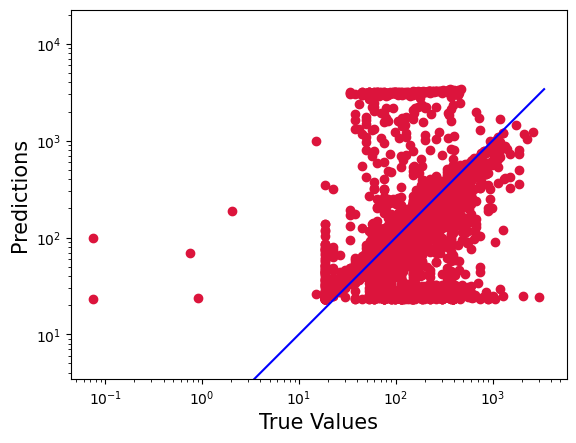

In [50]:
true_value = y_test
predicted_value = y_pred 

plt.scatter(true_value, predicted_value, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(predicted_value), max(true_value))
p2 = min(min(predicted_value), min(true_value))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

Model is still not performing well, lets try other models

In [51]:
# Getting old (non-normalized training testing split)
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7, random_state=101)

In [52]:
X_train['trip_duration_lb'], X_train['trip_duration_ub'] = remove_outliers(X_train['trip_duration'])
X_train

,trip_duration,distance_traveled,num_of_passengers,surge_applied,trip_duration_lb,trip_duration_ub
189352,580.0,3.20,1.0,0,-529.5,2074.5
93048,2466.0,10.17,1.0,0,-529.5,2074.5
151052,2477.0,10.96,1.0,1,-529.5,2074.5
24514,569.0,3.65,1.0,0,-529.5,2074.5
122346,294.0,2.06,1.0,0,-529.5,2074.5
...,...,...,...,...,...,...
55293,1632.0,6.12,1.0,1,-529.5,2074.5
49751,701.0,2.85,1.0,0,-529.5,2074.5
136767,47.0,0.82,1.0,0,-529.5,2074.5
204614,1063.0,12.55,5.0,0,-529.5,2074.5


In [53]:
X_train['distance_traveled_lb'], X_train['distance_traveled_ub'] = remove_outliers(X_train['distance_traveled'])
X_train

,trip_duration,distance_traveled,num_of_passengers,surge_applied,trip_duration_lb,trip_duration_ub,distance_traveled_lb,distance_traveled_ub
189352,580.0,3.20,1.0,0,-529.5,2074.5,-3.72,11.4
93048,2466.0,10.17,1.0,0,-529.5,2074.5,-3.72,11.4
151052,2477.0,10.96,1.0,1,-529.5,2074.5,-3.72,11.4
24514,569.0,3.65,1.0,0,-529.5,2074.5,-3.72,11.4
122346,294.0,2.06,1.0,0,-529.5,2074.5,-3.72,11.4
...,...,...,...,...,...,...,...,...
55293,1632.0,6.12,1.0,1,-529.5,2074.5,-3.72,11.4
49751,701.0,2.85,1.0,0,-529.5,2074.5,-3.72,11.4
136767,47.0,0.82,1.0,0,-529.5,2074.5,-3.72,11.4
204614,1063.0,12.55,5.0,0,-529.5,2074.5,-3.72,11.4


In [54]:
X_train = X_train.loc[(X_train['trip_duration'] <= X_train['trip_duration_ub']) & (X_train['distance_traveled'] <= X_train['distance_traveled_ub'])]
X_train

,trip_duration,distance_traveled,num_of_passengers,surge_applied,trip_duration_lb,trip_duration_ub,distance_traveled_lb,distance_traveled_ub
189352,580.0,3.20,1.0,0,-529.5,2074.5,-3.72,11.4
24514,569.0,3.65,1.0,0,-529.5,2074.5,-3.72,11.4
122346,294.0,2.06,1.0,0,-529.5,2074.5,-3.72,11.4
16038,1006.0,5.52,1.0,0,-529.5,2074.5,-3.72,11.4
155136,181.0,1.26,1.0,1,-529.5,2074.5,-3.72,11.4
...,...,...,...,...,...,...,...,...
208971,481.0,1.80,1.0,1,-529.5,2074.5,-3.72,11.4
55293,1632.0,6.12,1.0,1,-529.5,2074.5,-3.72,11.4
49751,701.0,2.85,1.0,0,-529.5,2074.5,-3.72,11.4
136767,47.0,0.82,1.0,0,-529.5,2074.5,-3.72,11.4


In [55]:
X_train = X_train[model_features]
X_train

,trip_duration,distance_traveled,num_of_passengers,surge_applied
189352,580.0,3.20,1.0,0
24514,569.0,3.65,1.0,0
122346,294.0,2.06,1.0,0
16038,1006.0,5.52,1.0,0
155136,181.0,1.26,1.0,1
...,...,...,...,...
208971,481.0,1.80,1.0,1
55293,1632.0,6.12,1.0,1
49751,701.0,2.85,1.0,0
136767,47.0,0.82,1.0,0


In [56]:
y_train = y_train[X_train.index]

In [57]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor()

In [58]:
y_pred = model.predict(X_test)
y_pred

array([178.725   , 190.575   ,  83.425   , ..., 199.725   ,  77.646875,
        42.6875  ])

In [59]:
comparing_dump_df = pd.DataFrame(y_test)
comparing_dump_df['Predicted Fare'] = y_pred
comparing_dump_df

,fare,Predicted Fare
160516,180.00,178.725000
193984,195.00,190.575000
170682,86.25,83.425000
205636,262.50,199.200000
149651,63.75,63.843750
...,...,...
84947,183.75,175.125000
4384,390.00,199.200000
159590,243.75,199.725000
190532,75.00,77.646875


In [60]:
r2_score(y_test, y_pred)

0.5153496551332868

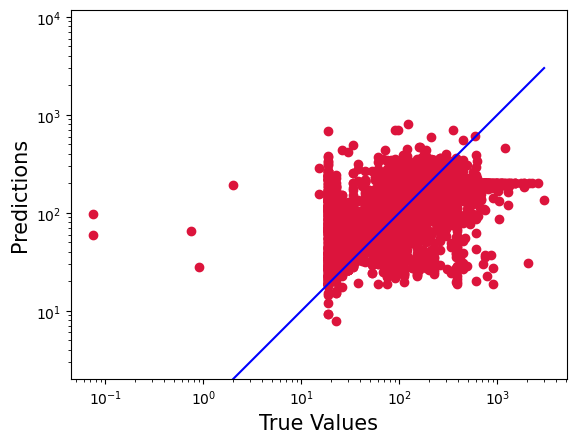

In [61]:
true_value = y_test
predicted_value = y_pred 

plt.scatter(true_value, predicted_value, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(predicted_value), max(true_value))
p2 = min(min(predicted_value), min(true_value))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

1. Tree based models are performing better, this might mean data is non-linearly related with target variable

In [62]:
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [63]:
y_pred = model.predict(X_test)
y_pred

array([182.0084 , 188.57011,  84.42816, ..., 200.37108, 132.79213,
        35.9163 ], dtype=float32)

In [64]:
r2_score(y_test, y_pred)

0.5131302938543972

In [65]:
comparing_dump_df = pd.DataFrame(y_test)
comparing_dump_df['Predicted Fare'] = y_pred
comparing_dump_df

,fare,Predicted Fare
160516,180.00,182.008408
193984,195.00,188.570114
170682,86.25,84.428162
205636,262.50,197.759125
149651,63.75,63.532425
...,...,...
84947,183.75,176.543259
4384,390.00,197.759125
159590,243.75,200.371078
190532,75.00,132.792130


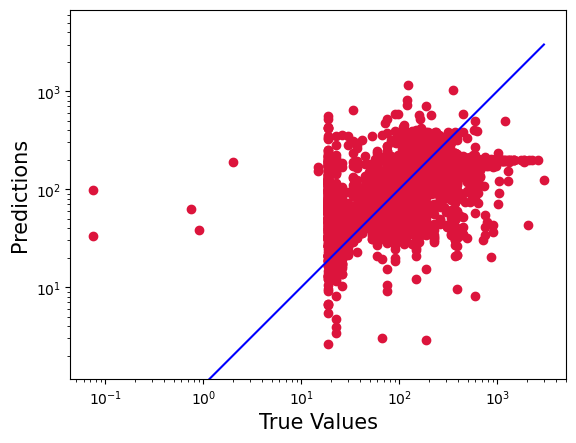

In [66]:
true_value = y_test
predicted_value = y_pred 

plt.scatter(true_value, predicted_value, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(predicted_value), max(true_value))
p2 = min(min(predicted_value), min(true_value))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

Performing same as RandomForestRegressor, which means Tree based model in-general works better in prediction

# **Developing additional features**

In [67]:
X_train

,trip_duration,distance_traveled,num_of_passengers,surge_applied
189352,580.0,3.20,1.0,0
24514,569.0,3.65,1.0,0
122346,294.0,2.06,1.0,0
16038,1006.0,5.52,1.0,0
155136,181.0,1.26,1.0,1
...,...,...,...,...
208971,481.0,1.80,1.0,1
55293,1632.0,6.12,1.0,1
49751,701.0,2.85,1.0,0
136767,47.0,0.82,1.0,0


In [68]:
# If a taxi has more than 6 passengers, then most probably its a big car. Hence, more fare
X_train['is_big_vehicle'] = np.where(X_train['num_of_passengers']> 6, 1, 0)
X_test['is_big_vehicle'] = np.where(X_test['num_of_passengers']> 6, 1, 0)

In [69]:
# If the distance travelled is alot (like >100+Kms) then mostly it will be out-of-station ride, Hence, more fare
X_train['distance_traveled'].describe()

count    131579.000000
mean          3.563913
std           2.382989
min           0.020000
25%           1.830000
50%           2.900000
75%           4.670000
max          11.390000
Name: distance_traveled, dtype: float64

In [70]:
X_train['is_out_of_station_ride'] = np.where(X_train['distance_traveled']> 100, 1, 0)
X_test['is_out_of_station_ride'] = np.where(X_test['distance_traveled']> 100, 1, 0)

In [71]:
# If trip duration is more than 1 hour, then most likely it will be charged more than usual (Need to confirm)
X_train['trip_duration'].describe()

count    131579.000000
mean        721.686394
std         407.032693
min           0.000000
25%         420.000000
50%         649.000000
75%         948.000000
max        2074.000000
Name: trip_duration, dtype: float64

In [72]:
X_train['is_more_than_hour_ride'] = np.where(X_train['trip_duration']> 3600, 1, 0)
X_test['is_more_than_hour_ride'] = np.where(X_test['trip_duration']> 3600, 1, 0)

In [73]:
## Data Correction
# If trip_duration is 0, then ideally it can't have any distance covered (might have fare due to many reasons like cancellation, etc)
X_train.loc[X_train['trip_duration'] == 0, 'distance_traveled'] = 0

In [74]:
new_model_features = ['trip_duration', 'distance_traveled', 'num_of_passengers',
       'surge_applied', 'is_big_vehicle', 'is_out_of_station_ride',
       'is_more_than_hour_ride']

In [75]:
model = RandomForestRegressor()
model.fit(X_train[new_model_features], y_train)

RandomForestRegressor()

In [76]:
y_pred = model.predict(X_test)
y_pred

array([180.15     , 193.4625   ,  83.315625 , ..., 200.8875   ,
        84.9453125,  44.0734375])

In [77]:
comparing_dump_df = pd.DataFrame(y_test)
comparing_dump_df['Predicted Fare'] = y_pred
comparing_dump_df

,fare,Predicted Fare
160516,180.00,179.100000
193984,195.00,191.718750
170682,86.25,83.312500
205636,262.50,196.575000
149651,63.75,64.100000
...,...,...
84947,183.75,175.275000
4384,390.00,196.575000
159590,243.75,199.087500
190532,75.00,81.519357


In [78]:
r2_score(y_test, y_pred)

0.5111123430181318

R2 Score increased abit, this leads me to believe the features are well suiting the data

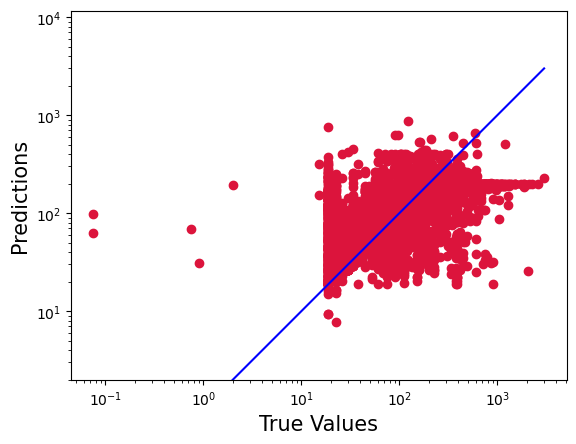

In [79]:
true_value = y_test
predicted_value = y_pred 

plt.scatter(true_value, predicted_value, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(predicted_value), max(true_value))
p2 = min(min(predicted_value), min(true_value))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

Text(0, 0.5, 'Predicted Fare')

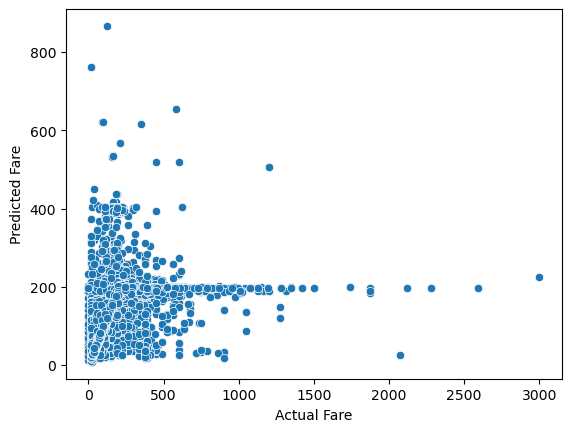

In [80]:
sns.scatterplot(x = y_test, y = y_pred)
plt.xlabel('Actual Fare')
plt.ylabel('Predicted Fare')

The above plot signifies alot of time model predicts fare close to 200, why is that?

# **Analyis on huge deviating cases**

In [81]:
comparing_dump_df['Percentage Difference'] = np.abs((comparing_dump_df['Predicted Fare'] - comparing_dump_df['fare']) / comparing_dump_df['fare']) * 100
comparing_dump_df

,fare,Predicted Fare,Percentage Difference
160516,180.00,179.100000,0.500000
193984,195.00,191.718750,1.682692
170682,86.25,83.312500,3.405797
205636,262.50,196.575000,25.114286
149651,63.75,64.100000,0.549020
...,...,...,...
84947,183.75,175.275000,4.612245
4384,390.00,196.575000,49.596154
159590,243.75,199.087500,18.323077
190532,75.00,81.519357,8.692476


In [82]:
analysis_data = X_test.loc[comparing_dump_df[comparing_dump_df['Percentage Difference'] >= 30].index]
analysis_data

,trip_duration,distance_traveled,num_of_passengers,surge_applied,is_big_vehicle,is_out_of_station_ride,is_more_than_hour_ride
173249,925.0,1.66,1.0,0,0,0,0
206581,5287.0,17.14,1.0,0,0,0,1
197945,3472.0,3.73,1.0,0,0,0,0
146716,3300.0,25.40,1.0,0,0,0,0
126181,3113.0,32.51,1.0,0,0,0,0
...,...,...,...,...,...,...,...
60253,21.0,0.06,1.0,0,0,0,0
189966,33.0,0.05,1.0,0,0,0,0
133669,833.0,15.39,1.0,0,0,0,0
179175,488.0,2.38,1.0,0,0,0,0


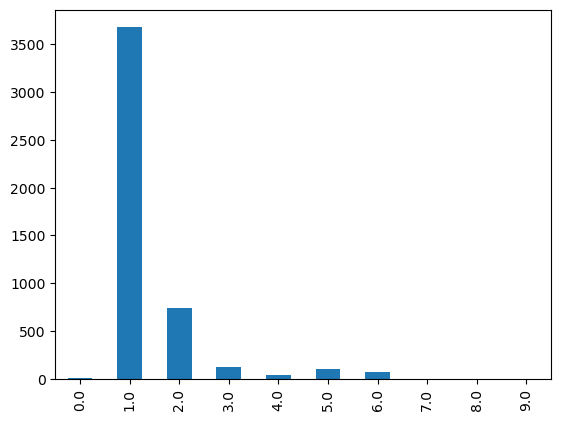

In [83]:
analysis_data['num_of_passengers'].value_counts().sort_index().plot(kind='bar')
plt.show()

Most of the cases where deviations are large are where passenger count is 1. Why?

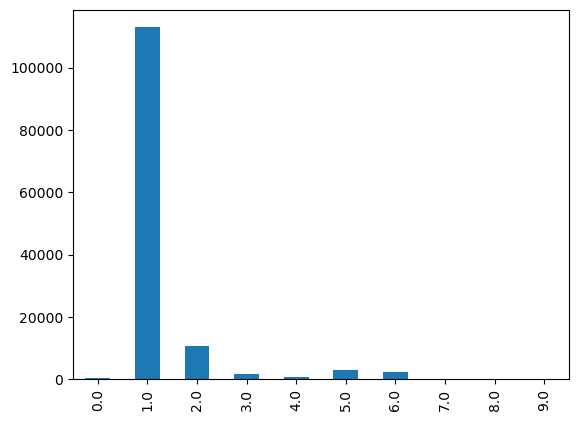

In [84]:
X_train['num_of_passengers'].value_counts().sort_index().plot(kind='bar')
plt.show()

Might be becuase most of the data is belonging to passenger count as 1

What does 0 passenger count mean? Did the taxi work as courier service? 

In [85]:
# For current senarios num_of_passengers = 0 means nothing, so we may remove that data
X_train['num_of_passengers'].value_counts()

1.0    112956
2.0     10705
5.0      2967
6.0      2172
3.0      1720
4.0       552
0.0       485
8.0        16
9.0         5
7.0         1
Name: num_of_passengers, dtype: int64

485 data points can be removed, or if they come in future we can treat as passenger count 1

In [86]:
X_train['num_of_passengers'] = np.where(X_train['num_of_passengers'] == 0, 1, X_train['num_of_passengers'])
# X_test['num_of_passengers'] = np.where(X_test['num_of_passengers'] == 0, 1, X_test['num_of_passengers'])

In [87]:
analysis_data['surge_applied'].value_counts()

0    3983
1     806
Name: surge_applied, dtype: int64

Most of the data where surge is not present, there are deviations

In [88]:
comparing_dump_df['Percentage Difference'].describe()

count    6.290200e+04
mean              inf
std               NaN
min      0.000000e+00
25%      1.083333e+00
50%      3.108288e+00
75%      6.615385e+00
max               inf
Name: Percentage Difference, dtype: float64

There are cases which are inf in Percentage Difference, why?

In [89]:
comparing_dump_df[comparing_dump_df['Percentage Difference'] == np.inf]

,fare,Predicted Fare,Percentage Difference
26437,0.0,44.548929,inf
51040,0.0,187.162500,inf
94702,0.0,71.437500,inf
31199,0.0,56.070000,inf
8930,0.0,196.575000,inf
166232,0.0,33.037500,inf
2389,0.0,61.429464,inf
185143,0.0,74.175000,inf
173371,0.0,41.702500,inf
167253,0.0,60.300000,inf


Why fares are zero for them?

In [90]:
train_df.loc[comparing_dump_df[comparing_dump_df['Percentage Difference'] == np.inf].index]

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,total_fare,surge_applied,final_fare_calculated_as_sum_of_components
26437,408.0,1.13,1.0,0.0,0,0.000,0.000,0,0.000
51040,1564.0,17.54,1.0,0.0,0,0.000,0.000,0,0.000
94702,752.0,2.41,1.0,0.0,0,0.000,0.000,0,0.000
31199,73.0,0.16,1.0,0.0,0,0.000,0.000,0,0.000
8930,3706.0,14.00,1.0,0.0,0,0.000,0.000,0,0.000
166232,226.0,0.80,1.0,0.0,112,0.500,112.500,0,112.500
2389,588.0,2.41,1.0,0.0,0,0.000,0.000,0,0.000
185143,825.0,2.25,1.0,0.0,0,0.000,0.000,0,0.000
173371,29.0,0.48,1.0,0.0,0,0.000,0.000,0,0.000
167253,164.0,0.48,1.0,0.0,0,0.000,0.000,0,0.000


Fare for these rides seems to be 0, why?
1. There is no reason given, so assuming incorrect data
2. This also resolves our issue of ~0.51 R2 Score (why is it low) - mostly due to these edge cases

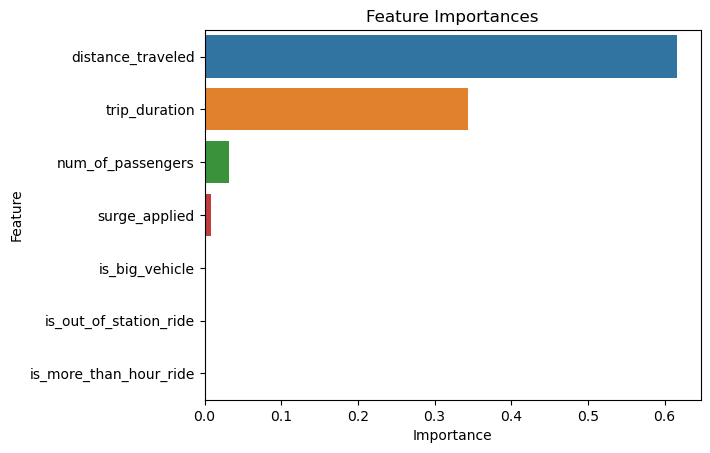

In [91]:
# Checking feature importance
feature_importances = pd.DataFrame({'Feature': new_model_features, 'Importance': model.feature_importances_})

# Sort the DataFrame by importance values in descending order
feature_importances = feature_importances.sort_values('Importance', ascending=False)

# Plot the feature importances
sns.barplot(x='Importance', y='Feature', data=feature_importances, orient='h')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

1. All the self developed features are having little to 0 feature importance. Maybe due to same information already being extracted from original features
2. Maybe new features are having 0 weights due to lack of training data in X_train, but present in X_test
3. Distance travelled is highly important, can more meaningful features be created like bins based features (0-10kms, 10-20kms, etc)

In [77]:
X_train['is_big_vehicle'].value_counts()

is_big_vehicle
0    131557
1        22
Name: count, dtype: int64

Mostly looks like due to lack of training data it is showing this result
* We can try CV on training data so it can learn the correct weights

In [78]:
X_train['is_out_of_station_ride'].value_counts()

is_out_of_station_ride
0    131579
Name: count, dtype: int64

In [79]:
X_train['is_more_than_hour_ride'].value_counts()

is_more_than_hour_ride
0    131579
Name: count, dtype: int64